<a href="https://colab.research.google.com/github/ryosuke0624/image_search_minimum/blob/master/shoes_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

画像検索を最小限のコードで実装するnotebookです。

# データの準備

In [3]:
# 画像データのダウンロード & 解凍
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip -qq ut-zap50k-images.zip

--2020-07-13 04:10:15--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

ut-zap50k-images.zi 100%[===================>] 291.18M  14.9MB/s    in 21s     

2020-07-13 04:10:37 (14.0 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



[todo] ut-zap50k-imagesのディレクトリ構造を説明する。

[todo] ターゲットを構成する方針を説明する。

In [4]:
import glob
import shutil
from pathlib import Path

cat_path_list = glob.glob("ut-zap50k-images/*/*")
cat_list = ['-'.join(path.replace(" ", "_").split('/')[1:]) for path in cat_path_list]

!mkdir images

for i, cat_path in enumerate(cat_path_list):
  p = Path(f'images/{cat_list[i]}')
  if not p.exists():
    p.mkdir()
  for image_path in glob.glob(cat_path + '/*/*'):
    dest = shutil.move(image_path, f'images/{cat_list[i]}/{Path(image_path).name}')

In [5]:
import os
import numpy as np
import pandas as pd

# Any results you write to the current directory are saved as output.
import gc
gc.collect()

47

In [6]:
import fastai

from fastai import *
from fastai.vision import *

# from torchvision.models import *
# import pretrainedmodels

#from utils import *
import sys

from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [7]:
path = Path("images/")

# [todo] 色々やりすぎなので、必要最低限に減らす
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

src = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed=42)
        .label_from_folder())

In [8]:
data = (src.transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128)
        .databunch(bs=64, num_workers=0)
        .normalize(imagenet_stats))

In [9]:
data

ImageDataBunch;

Train: LabelList (40020 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Shoes-Boat_Shoes,Shoes-Boat_Shoes,Shoes-Boat_Shoes,Shoes-Boat_Shoes,Shoes-Boat_Shoes
Path: images;

Valid: LabelList (10005 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Shoes-Loafers,Shoes-Loafers,Shoes-Sneakers_and_Athletic_Shoes,Shoes-Loafers,Boots-Ankle
Path: images;

Test: None

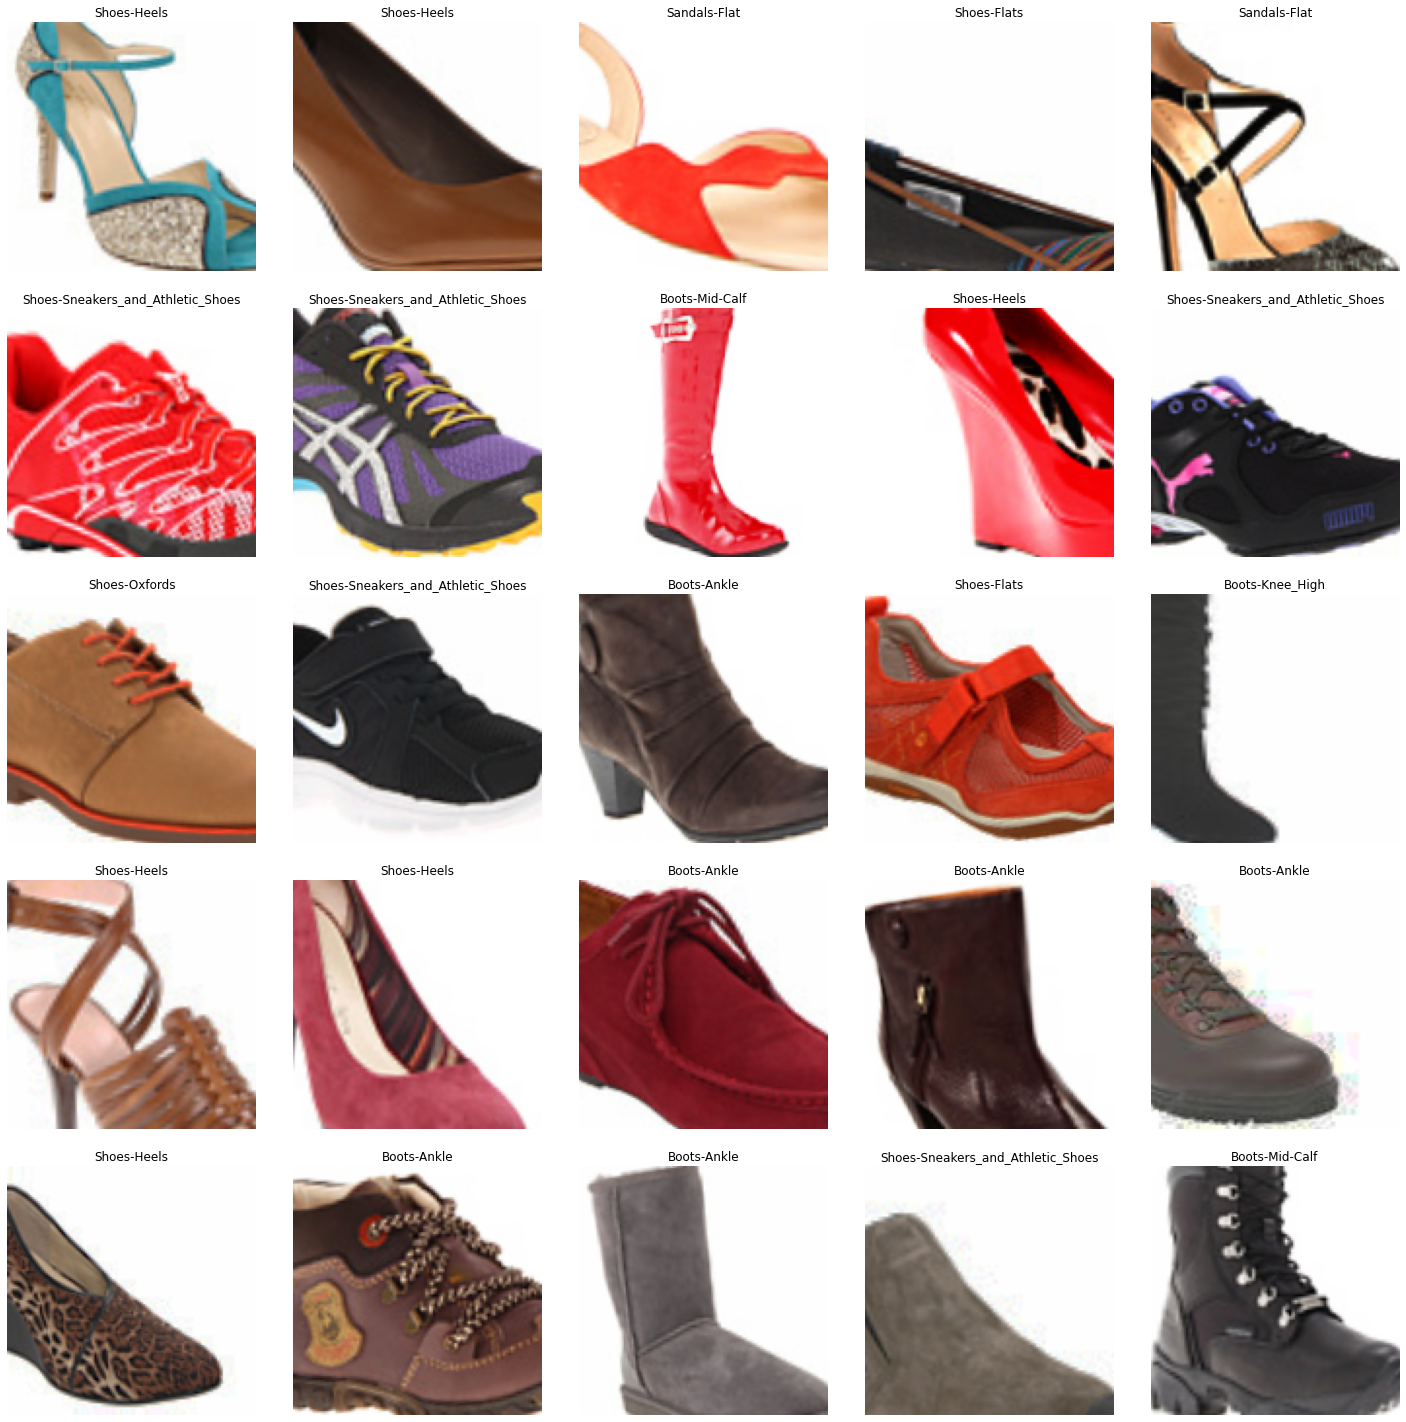

In [10]:
data.show_batch()

In [11]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Boots-Ankle', 'Boots-Knee_High', 'Boots-Mid-Calf', 'Boots-Over_the_Knee', 'Boots-Prewalker_Boots', 'Sandals-Athletic', 'Sandals-Flat', 'Sandals-Heel', 'Shoes-Boat_Shoes', 'Shoes-Clogs_and_Mules', 'Shoes-Crib_Shoes', 'Shoes-Firstwalker', 'Shoes-Flats', 'Shoes-Heels', 'Shoes-Loafers', 'Shoes-Oxfords', 'Shoes-Prewalker', 'Shoes-Sneakers_and_Athletic_Shoes', 'Slippers-Boot', 'Slippers-Slipper_Flats', 'Slippers-Slipper_Heels']


# モデルの学習

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir="model" ).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 6.92E-03


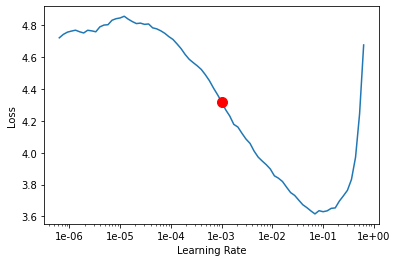

In [13]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
lr=1e-3
learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.365873,0.898623,0.711244,05:59
1,1.111645,0.873553,0.714243,05:54


In [15]:
learn.save('polyvore_final_model')

# 画像の特徴量抽出

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [17]:
# Second last layer of the model
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [18]:
sf = SaveFeatures(learn.model[1][4])

In [19]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [20]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) + list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]

In [21]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
df_new['img_repr'] = np.array(sf.features).tolist()

# 近似近傍探索

In [23]:
!pip install annoy
from annoy import AnnoyIndex

     |████████████████████████████████| 645kB 11.2MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297332 sha256=096ae782cda123240026cd60fa962eb4253be21271cf3f79b3714352ec0b305f
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [24]:
f = len(df_new['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [25]:
ntree = 50

for i, vector in enumerate(df_new['img_repr']):
    t.add_item(i, vector)
_  = t.build(ntree)

In [26]:
import time
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    similar_img_ids = t.get_nns_by_item(img_index, 8)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [27]:
base_image, base_label, similar_images_df = get_similar_images_annoy(1000)

2.7320384979248047 ms


In [28]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

1.3017654418945312 ms


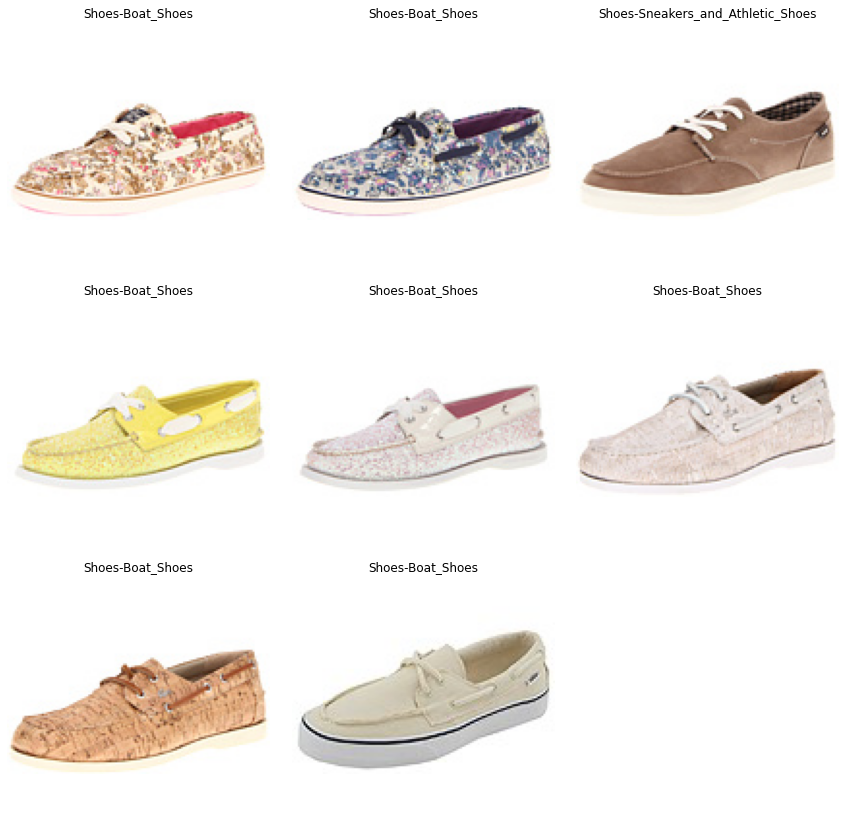

In [30]:
base_image, base_label, similar_images_df = get_similar_images_annoy(3)
show_similar_images(similar_images_df)